In [85]:
import  os
import  pylab                as      pl
import  numpy                as      np
import  matplotlib.pyplot    as      plt
from    astropy.table        import  Table
import  fitsio
from    desitarget.cmx       import  cmx_targetmask
from    desitarget           import  targetmask
import  desimodel.focalplane

%matplotlib inline

In [120]:
plt.rcParams['figure.figsize'] = [10, 10]

In [32]:
# reference to tile description https://desi.lbl.gov/trac/wiki/TargetSelectionWG/miniSV2
# path to data http://www.astro.utah.edu/~u6022465/SV/miniSV/

In [95]:
# 40 standard stars per petal (STD_BRIGHT for the BGS+MWS tiles, STD_FAINT for other tiles); this is 4X nominal: 400 per tile. 
# 80 skies per petal; this is 2X nominal: 800 per tile. 
# SV0_WD at highest priority

In [33]:
scratch = '/global/cscratch1/sd/mjwilson'
root    = scratch + '/BGS/MINISV/'

In [34]:
tiles   = ['070500', '070501', '070502', '070503', '070508']

In [35]:
# -----------  Span the night  ------------------------
# 119.00	50.00	Nothing in particular here, but higher declination
# 135.00	0.50	GAMA-G09
# 217.50	0.50	GAMA-G15
# 195.00	29.00	Coma on petal 0 

In [36]:
tile_files = {}

for i, tile in enumerate(tiles):
  tile_files[i] = root + '/{}/fiberassign-{}.fits'.format(tile, tile)

In [ ]:
area     = np.pi * desimodel.focalplane.get_tile_radius_deg()**2
flux_cut = 10**((22.5-19.5)/2.5)

for i, tile in enumerate(tiles):
    print('---------------------------------------------------------')
    
    print("TILE: {}\n".format(tile))
    print('---------------------------------------------------------')
    
    targets   = Table(fitsio.read(tile_files[i], ext='TARGETS'))
    assigned  = Table(fitsio.read(tile_files[i], ext='FIBERASSIGN'))
    
    # targets.pprint(max_width=-1)
    
    is_minisv = (assigned['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('MINI_SV_BGS_BRIGHT')) != 0
    is_SV0    = (assigned['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0
    is_lslga  = (assigned['REF_CAT'] == 'L2')
    is_mws    = (assigned['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_MWS')) != 0
    
    dudfiber  =  assigned['FIBERSTATUS'] > 0
    
    flux_r    =  assigned['FLUX_R'] / assigned['MW_TRANSMISSION_R']
    rmag      =  22.5 - 2.5*np.log10(flux_r)

    isin      =  [x in assigned['TARGETID'] for x in targets['TARGETID']]
    targets   =  targets[isin]
    
    supp      = (targets['DESI_TARGET'] & targetmask.desi_mask.mask('SUPP_SKY')) != 0 
    badsky    = (targets['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('BAD_SKY')) != 0 

    targets.sort('TARGETID')
    assigned.sort('TARGETID')
    
    print('MINI_SV_BGS_BRIGHT:  ', np.count_nonzero(is_minisv))
    print('MINI_SV_BGS_BRIGHT DENSITY (targets/deg^2):  {}'.format(np.count_nonzero(is_minisv) / area))
        
    print('\nSV0_BGS":  ', np.count_nonzero(is_SV0))
    print('SV0_BGS DENSITY (targets/deg^2):  {}'.format(np.count_nonzero(is_SV0) / area))
    
    print('\nMINISV & SV0_BGS:  ', np.count_nonzero(is_SV0 & is_minisv))

    print('\nLSLGA & (MINISV | SV0_BGS):  ', np.count_nonzero(is_SV0 & is_lslga) + np.count_nonzero(is_minisv & is_lslga))

    print('\nGAIA STANDARDS (DITHER):  {} of 400 required'.format(np.count_nonzero((assigned['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('STD_GAIA'))!=0)))
    print('\nFAINT STANDARDS:  {} of 400 required'.format(np.count_nonzero((assigned['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('STD_FAINT'))!=0)))
    print('\nBRIGHT STANDARDS:  {} of 400 required'.format(np.count_nonzero((assigned['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('STD_BRIGHT'))!=0)))
    
    print('\nSV0 FAINT STANDARDS:  {} of 400 required'.format(np.count_nonzero((assigned['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_STD_FAINT'))!=0)))
    print('\nSV0 BRIGHT STANDARDS:  {} of 400 required'.format(np.count_nonzero((assigned['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_STD_BRIGHT'))!=0)))

    print('\nSKY:  {} of 800 required.'.format(np.count_nonzero(assigned['OBJTYPE'] == 'SKY')))
    print('\nSUPP. SKY', np.count_nonzero(supp))
    print('\nBAD SKY', np.count_nonzero(badsky))
    
    print('\nDUD FIBERS: {}'.format(np.count_nonzero(dudfiber)))
    
    unique_cmxtargets = np.array([x for x in set(assigned['CMX_TARGET'])])
    unique_cmxtargets = np.sort(np.array(unique_cmxtargets))

    print('\n\nSkies and Stds. breakdown:\n\n')
    
    unique_desitargets = np.array([x for x in set(assigned['DESI_TARGET'])])
    unique_desitargets = np.sort(np.array(unique_desitargets))
    
    for i in unique_desitargets:
        print('{} \t\t {:<16} \t\t {}'.format(np.count_nonzero(assigned['DESI_TARGET'] == i), i, '\t'.join(x for x in targetmask.desi_mask.names(i))))
    
    print('\n\nTarget breakdown:  \n\n')
    
    for i in unique_cmxtargets:
        print('{} \t\t {:<16} \t\t {}'.format(np.count_nonzero(assigned['CMX_TARGET'] == i), i, '\t'.join(x for x in cmx_targetmask.cmx_mask.names(i))))
    
    print('\n\n')
    
print('Done.\n\n')

---------------------------------------------------------
TILE: 070500

---------------------------------------------------------


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide


#  Details per tile 

In [81]:
# Why is this not set?
print(np.unique(targets['FIBER']))

FIBER
-----
    0


In [57]:
np.unique(assigned['FA_TYPE'], return_counts=True)

(<Column name='FA_TYPE' dtype='uint8' length=4>
  1
  3
  4
 16, array([4132,  100,  767,    1]))

In [69]:
np.unique(assigned['REF_CAT'], return_counts=True)

(<Column name='REF_CAT' dtype='bytes2' length=3>
   
 G2
 L2, array([3848, 1024,  128]))

In [59]:
np.unique(assigned['OBJTYPE'], return_counts=True)

(<Column name='OBJTYPE' dtype='bytes3' length=2>
 SKY
 TGT, array([ 767, 4233]))

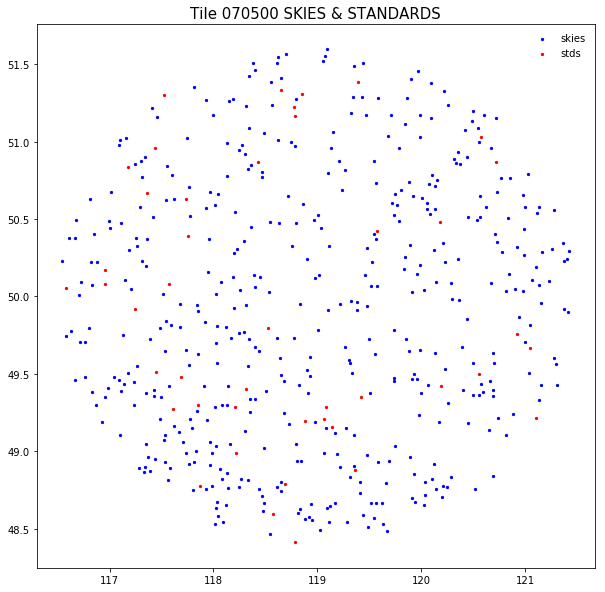

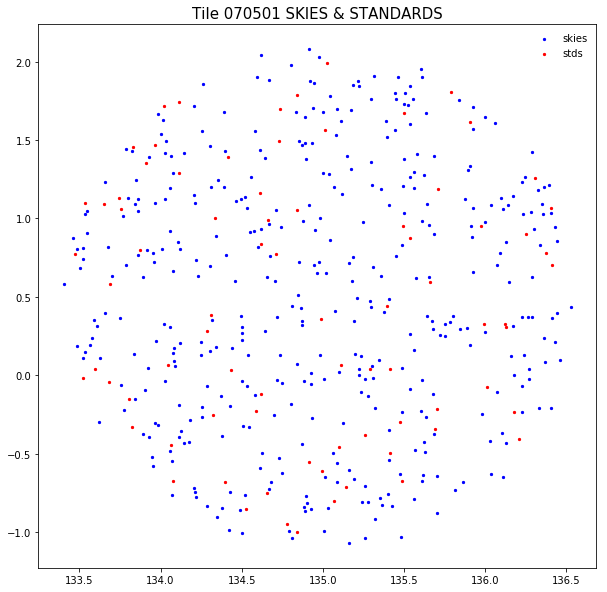

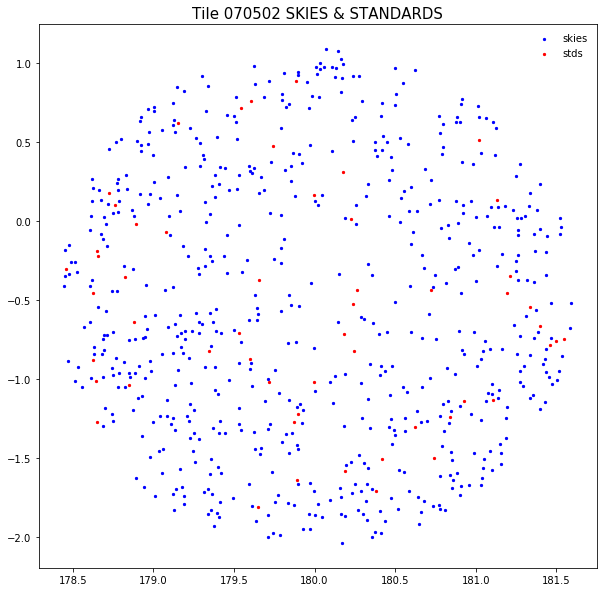

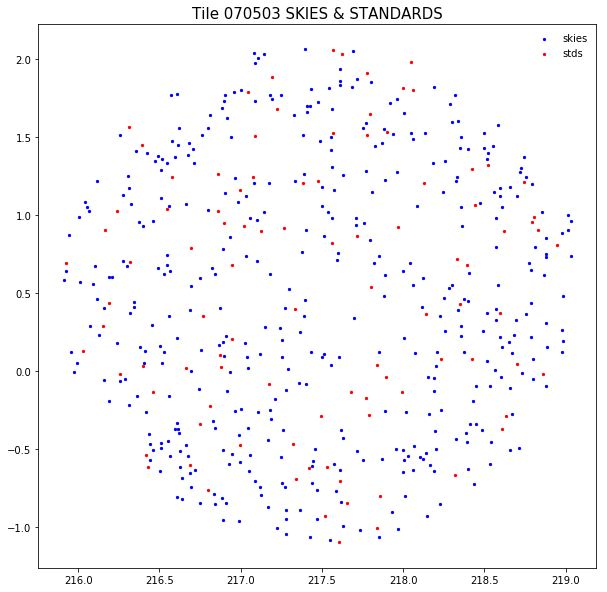

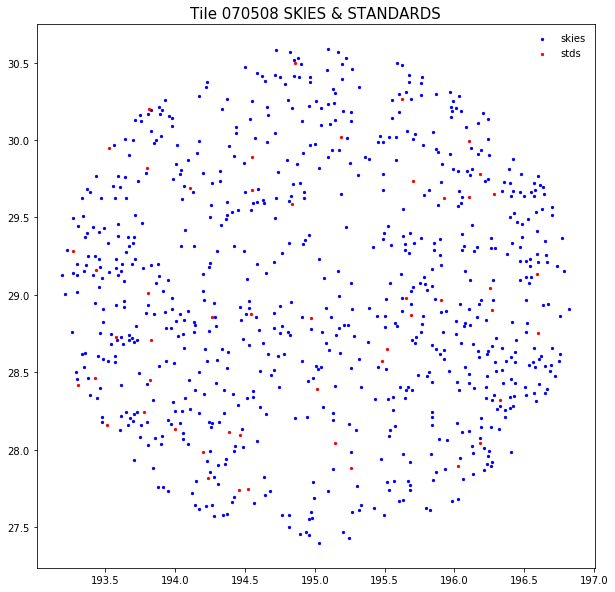

In [149]:
for i, tile in enumerate(tiles):    
    targets   = Table(fitsio.read(tile_files[i], ext='TARGETS'))
    assigned  = Table(fitsio.read(tile_files[i], ext='FIBERASSIGN'))

    sky       =  assigned['OBJTYPE']== 'SKY'
    std       = (assigned['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_STD_BRIGHT')) != 0
    
    plt.scatter(assigned['TARGET_RA'][sky],  assigned['TARGET_DEC'][sky],  s=5, c='b', label='skies')
    plt.scatter(assigned['TARGET_RA'][std],  assigned['TARGET_DEC'][std],  s=5, c='r', label='stds')
    
    pl.legend(frameon=False)
    plt.title("Tile {} SKIES & STANDARDS".format(tile), size=15)
    pl.show()

In [160]:
# cmx_targetmask.cmx_mask.names

In [159]:
print('\n\nDone.\n\n')



Done.


